# Practical work 7: Split and Merge

In this practical work, we implement and test the split and merge algorithm.

In [86]:
### Usefull libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from IPython.display import HTML

### Data
img_test = np.full((64,64),150,dtype=np.uint8)
img_test[32:48,16:16+32] = 100
img_test[8:24,40:56] = 50
angio = np.array(Image.open('img/angiogra.png'))
cam = np.array(Image.open('img/cameraman.png'))
muscle = np.array(Image.open('img/muscle.png'))
prisme = np.array(Image.open('img/prisme.png'))
seiche = np.array(Image.open('img/seiche.png'))

### Useful functions
def imshow(I, title=None, size=500, axis=True):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I,vmin=0,vmax=255)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal', vmin=0, vmax=255)

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def neighbors(b,K):
    """ blockStat*list[blockStat]->list[blockStat]
        returns the list of neighbors of b and elements of K 
    """
    def belongsTo(x,y,a):
        """ int*int*BlockStat -> bool 
            Test if pixel (x,y) belongs to block a 
        """
        return x>=a[0] and y>=a[1] and x<a[0]+a[2] and y<a[1]+a[3]
    def areNeighbors(a,b):
        """ BlockStat**2 -> bool
            Test if a and b are neighbors
        """
        if a[2]>b[2] and a[3]>b[3]:
            a,b=b,a
        x,y = a[0]+a[2]//2,a[1]+a[3]//2
        return belongsTo(x+a[2],y,b) or belongsTo(x-a[2],y,b) or belongsTo(x,y+a[3],b) or belongsTo(x,y-a[3],b)
    N = []
    for n in K:
        if areNeighbors(b,n):
            N.append(n)
    return N


## Exercise 1

### Question 1
Write the recursive function ``split()`` discussed in tutorial work. 
It takes as input the image, a region, a predicate, and a variable number of arguments. 
The region is a Python formal type ``Block`` defined by:
```python
type Block = tuple[int**4]
```
The function ``split()`` returns a quadtree, a Python formal type, recursivelly defined by:
```python
type QuadTree = list[(QuadTree**4|Block)] 
```

The predicate is a Python function with the following signature:
```python
Array*Block*...->bool
```
It can take a variable number of parameters which correspond to the parameters required by the predicate.

In [2]:
# type Block = tuple[int**4]
# type QuadTree = list[(QuadTree**4|Block)] 

def split(I,reg,pred,*args):
    """ Array*Block*(Array*Block*...->bool)*... -> 4-aire
        Performs a quadtree splitting of image I drived by a predicate
    """
    x, y, n, m = reg
    if pred(I,reg,*args) and n > 2 and m > 2:
        n2, m2 = n//2, m//2
        nw = split(I, (x, y, n2, m2), pred, *args)
        ne = split(I, (x, y+m2, n2, m2), pred, *args)
        sw = split(I, (x+n2, y, n2, m2), pred, *args)
        se = split(I, (x+n2, y+m2, n2, m2), pred, *args)
        return [nw, ne, sw, se]
    return [reg]

### Question 2
Write the function ```predsplit(I,B,*args)``` with signature:
```python
Array*Block*... -> bool
```
that returns `True` if the standard deviation of image ``I`` computed in region ``B`` is greater than the first value of argument ``*args`` (it can be accessed simply by ``*args[0]``).

In [3]:
def predsplit(I,reg,*args):
    """ Array*Block*... -> bool
    """ 
    x,y,n,m = reg
    return I[x:x+n,y:y+m].std() > args[0]

### Question 3
Write the function ``listRegions()`` which applies a depth-first search on the quadtree given as parameter, and returns the list of the leaves of the quadtree. 

Some recalls about lists in Python;
 - Initialization: `L = []` (empty list)
 - Add a element `a` into a list `L`: `L.append(a)`

In [4]:
def listRegions(L):
    """ QuadTree -> list[Block]
    """
    reg = []
    if len(L) == 1:
        reg.append(L[0])
    else:
        for i in range(4):
            reg += listRegions(L[i])
    return reg

### Question 4
Test your codes on the synthetic image ``img_test`` seen in tutorial work. Print the value returned by ``split()`` as well as the one returned by ``listRegions()``. 

In [5]:
n,m = img_test.shape

quadtree = split(img_test, (0,0,n,m), predsplit, 0)
reg = listRegions(quadtree)

print("QuadTree:\n", quadtree)
print("-----------------------")
print("Regions:\n", reg)

QuadTree :
 [[(0, 0, 32, 32)], [[[(0, 32, 8, 8)], [(0, 40, 8, 8)], [(8, 32, 8, 8)], [(8, 40, 8, 8)]], [[(0, 48, 8, 8)], [(0, 56, 8, 8)], [(8, 48, 8, 8)], [(8, 56, 8, 8)]], [[(16, 32, 8, 8)], [(16, 40, 8, 8)], [(24, 32, 8, 8)], [(24, 40, 8, 8)]], [[(16, 48, 8, 8)], [(16, 56, 8, 8)], [(24, 48, 8, 8)], [(24, 56, 8, 8)]]], [[(32, 0, 16, 16)], [(32, 16, 16, 16)], [(48, 0, 16, 16)], [(48, 16, 16, 16)]], [[(32, 32, 16, 16)], [(32, 48, 16, 16)], [(48, 32, 16, 16)], [(48, 48, 16, 16)]]]
-----------------------
Regions :
 [(0, 0, 32, 32), (0, 32, 8, 8), (0, 40, 8, 8), (8, 32, 8, 8), (8, 40, 8, 8), (0, 48, 8, 8), (0, 56, 8, 8), (8, 48, 8, 8), (8, 56, 8, 8), (16, 32, 8, 8), (16, 40, 8, 8), (24, 32, 8, 8), (24, 40, 8, 8), (16, 48, 8, 8), (16, 56, 8, 8), (24, 48, 8, 8), (24, 56, 8, 8), (32, 0, 16, 16), (32, 16, 16, 16), (48, 0, 16, 16), (48, 16, 16, 16), (32, 32, 16, 16), (32, 48, 16, 16), (48, 32, 16, 16), (48, 48, 16, 16)]


### Question 5
Write the function ```drawRegions(L,I)``` which takes as arguments a list of regions, an image, and returns an image  where the boundaries of each region have been traced with red color. Indication: the returned image is a hypermatrix of dimension 3, the third dimension is of size 3 and encodes the red, green and blue components of a RGB colorspace. Test the function on the previous example.

To transform our image in RGB, we can iterate on each pixels and add each pixel 3 times to an array of size 3 :
```python
rgb = np.zeros((n,m,3))    
for x in range(n):
    for y in range(m):
        rgb[x,y] = [I[x,y],I[x,y],I[x,y]]
```
But we can simply use this one-liner thanks to `numpy` and `python` :
```python
rgb = np.stack([img]*3, axis=-1)
```

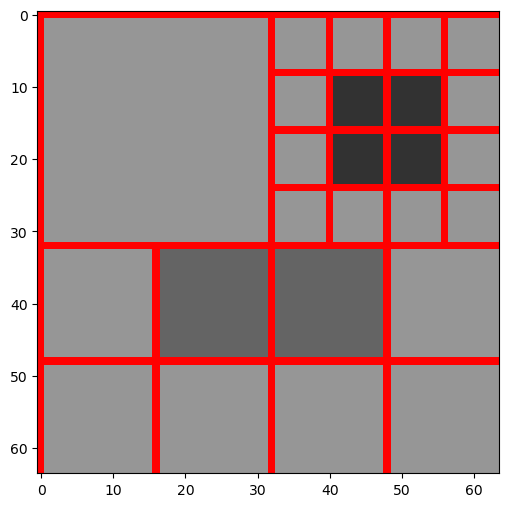

In [6]:
def drawRegions(L,I):
    """ list[Block]*Array -> Array
        draw the boundaries of each region
    """
    n,m = I.shape
    rgb = np.stack([I]*3, axis=-1)
    
    for region in L:
        x,y,n,m = region
        rgb[x:x+n, y] = [255,0,0]
        rgb[x, y:y+m] = [255,0,0]

    return rgb / 255

imshow(drawRegions(reg,img_test))

### Question 6
Add a Gaussian noise with standard deviation 5 to the image ``img_test``. 
Apply the quadtree splitting on the noisy image by adjusting the threshold to obtain the same result as in the previous question. 
Which threshold value should be chosen? Does this make sense to you?

Hint: use the Numpy function ``random.randn()`` which generates random values according to a normal distribution (Gaussian distribution of null mean and variance 1). To obtain realizations of a Gaussian distribution of standard deviation $\sigma$, it is sufficient to multiply by $\sigma$ the realizations of a normal distribution. 

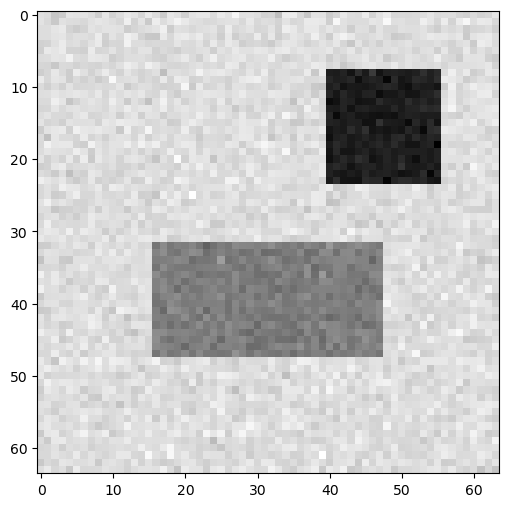

In [7]:
from numpy import random

def applyGaussian(I, sigma):
    n, m = I.shape
    return I + (sigma * np.random.randn(n,m))

imshow(applyGaussian(img_test, 5))

During tutorial work, we've seen that when we apply a Gaussian noise with standard deviation $\sigma$ to an image, the same value is applied to the leaves of our quadtree, so we should use $\sigma$ as our threshold value, logically. In practice, it's better to use a slightly higher value of $\sigma$, in our case we use $\sigma+1$.

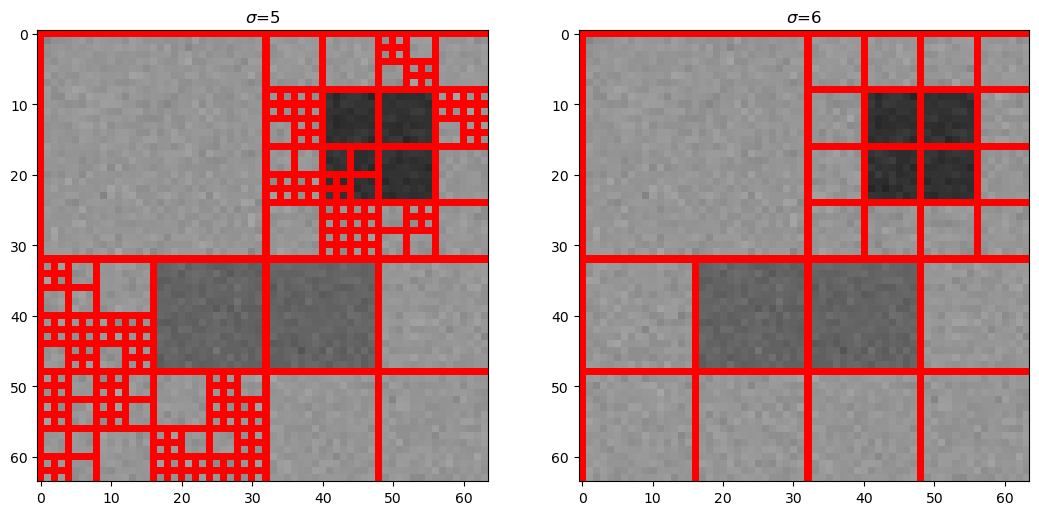

In [8]:
## parameters
sigma = 5
img_test_blurred = applyGaussian(img_test, sigma)

## splitting
quadtree1 = split(img_test_blurred, (0,0,n,m), predsplit, sigma)
quadtree2 = split(img_test_blurred, (0,0,n,m), predsplit, sigma+1)
reg1 = listRegions(quadtree1)
reg2 = listRegions(quadtree2)

## drawing regions
niceDisplay14([drawRegions(reg1,img_test_blurred),drawRegions(reg2,img_test_blurred)],
             titres=[f"$\sigma$={sigma}",f"$\sigma$={sigma+1}"])

## Exercise 2

Experiment the split algorithm on the 5 natural images provided. For each image try to find the threshold that seems to you visually the best. Display the number of regions obtained after splitting.

Once again, the hardest part is choosing a good threshold value that will create the best possible result. Because our splitting predicate (`predsplit`) is based upon the standard derivation of the regions of our image, we do know that it will be always counter-productive to have a threshold value higher than the standard derivation of our image. Thus, we know that our threshold value will never exceed the standard derivation of our image (let's call it $\sigma_I$): we can easily see that when our threshold value is greater than or equal to $\sigma_I$ ($thres \ge \sigma_I$), our split algorithm will create at most 1 region, which is definitely not what we are looking for. 

`animationSplit` allows us to create animations on our threshold and `computeSplit` allows us to get our image where the boundaries of each region have been traced with red color without having to worry about recomputing the quadtree or the regions.

In [9]:
def animateSplit(pred, I, name=""):
    n, m = I.shape
    qt = split(I, (0,0,n,m), predsplit, pred)
    reg = listRegions(qt)
    plt.imshow(drawRegions(reg,I), cmap="gray")
    plt.title(f"{name}, $thres={round(pred,2)}$, regions$={len(reg)}$")

def computeSplit(I, *args):
    """ Array -> Array
        computes quadtree, regions and the image where the regions has been traced 
        given an image
    """
    n, m = I.shape
    qt = split(I, (0,0,n,m), predsplit, args[0])
    reg = listRegions(qt)
    return drawRegions(reg,I)

Let's experiment.

In [10]:
print("Number of regions with thres < std(angio) :",
      len(listRegions(split(angio, (0,0,angio.shape[0],angio.shape[1]), predsplit, angio.std()-1))))
print("Number of regions with thres = std(angio) :",
      len(listRegions(split(angio, (0,0,angio.shape[0],angio.shape[1]), predsplit, angio.std()))))
print("Number of regions with thres > std(angio) :",
      len(listRegions(split(angio, (0,0,angio.shape[0],angio.shape[1]), predsplit, angio.std()+1))))

Number of regions with thres < std(angio) : 253
Number of regions with thres = std(angio) : 1
Number of regions with thres > std(angio) : 1


Standard deviation of `angio`: 33.76748539743484


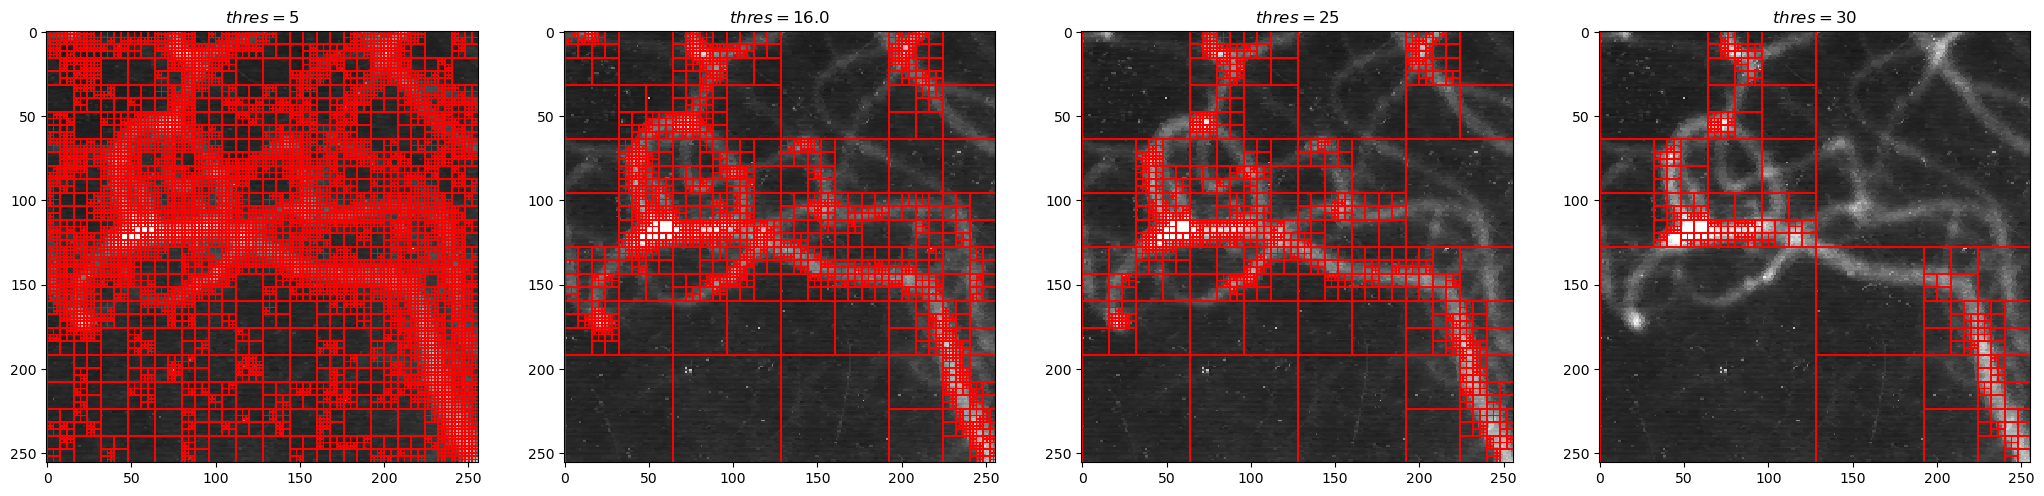

In [11]:
print("Standard deviation of `angio`:", angio.std())
niceDisplay14([computeSplit(angio, 5), computeSplit(angio, angio.std()//2), computeSplit(angio, 20), computeSplit(angio, 30)],
             titres=[f"$thres=5$", f"$thres={angio.std()//2}$", "$thres=25$", "$thres=30$"])


In [12]:
std = angio.std()
pred = np.linspace(0, std)
anim = animation.FuncAnimation(plt.figure(figsize=(4,4)), animateSplit, frames=pred, fargs=(angio,"angio",), 
                               interval=800, repeat=True)
anim.save('gif/angio_splitting_algorithm.gif')
plt.close()

![Threshold value impact on split algorithm illustrated on angio](gif/angio_splitting_algorithm.gif)

Standard deviation of `cam`: 62.34123968732711


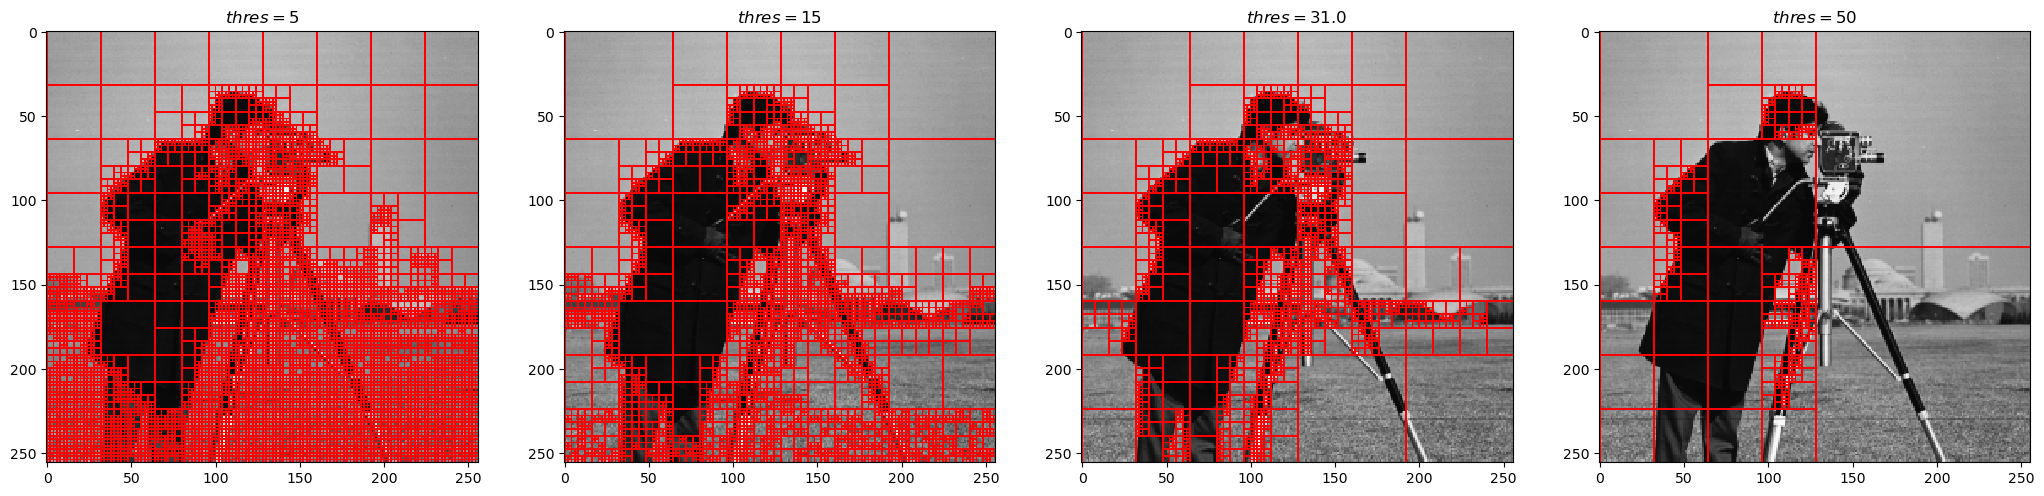

In [13]:
print("Standard deviation of `cam`:", cam.std())
niceDisplay14([computeSplit(cam, 5), computeSplit(cam, 15), computeSplit(cam, cam.std()//2), computeSplit(cam, 50)],
             titres=[f"$thres=5$", "$thres=15$", f"$thres={cam.std()//2}$", "$thres=50$"])

In [14]:
std = cam.std()
pred = np.linspace(0, std)
anim = animation.FuncAnimation(plt.figure(figsize=(4,4)), animateSplit, frames=pred, fargs=(cam,"cam",), 
                               interval=800, repeat=True)
anim.save('gif/cam_splitting_algorithm.gif')
plt.close()

![Threshold value impact on split algorithm illustrated on cam](gif/cam_splitting_algorithm.gif)

Standard deviation of `muscle`: 56.66370058179967


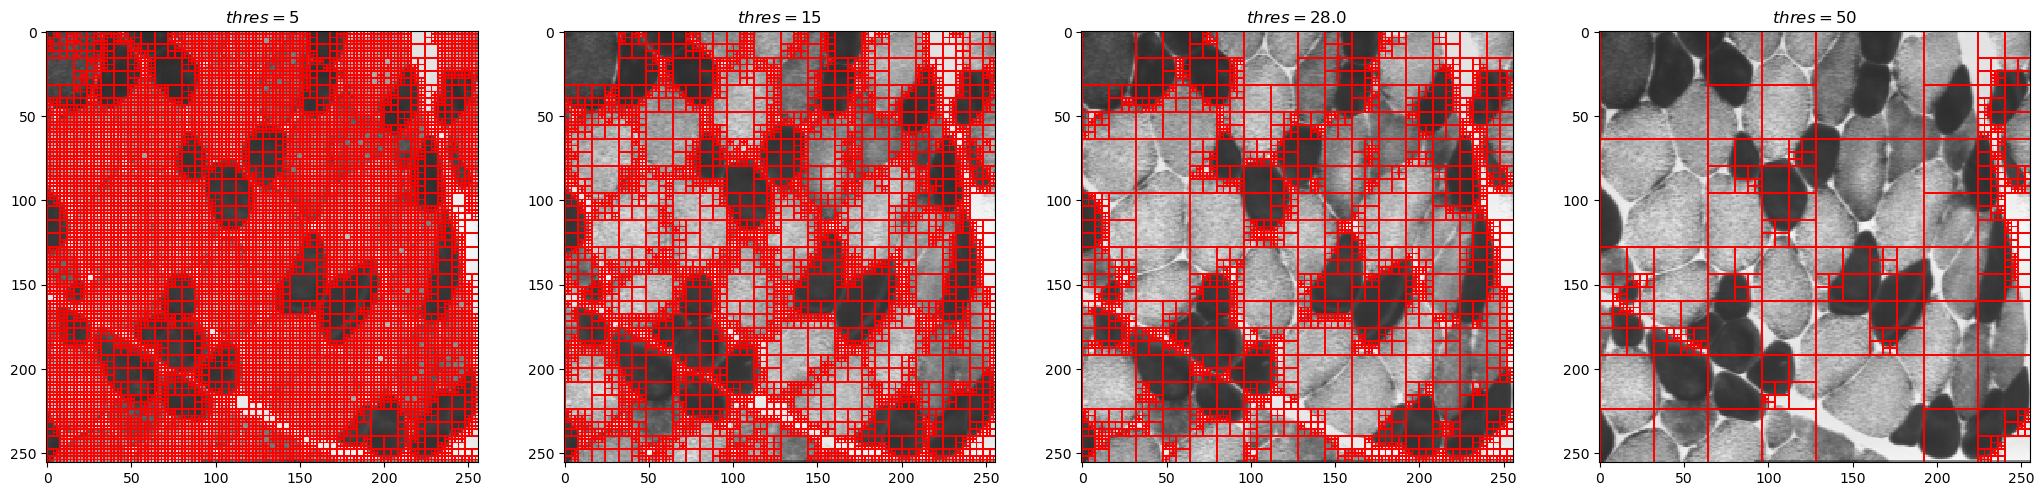

In [15]:
print("Standard deviation of `muscle`:", muscle.std())
niceDisplay14([computeSplit(muscle, 5), computeSplit(muscle, 15), 
               computeSplit(muscle, muscle.std()//2), computeSplit(muscle, 50)],
              titres=[f"$thres=5$", "$thres=15$", f"$thres={muscle.std()//2}$", "$thres=50$"])

In [16]:
std = muscle.std()
pred = np.linspace(0, std)
anim = animation.FuncAnimation(plt.figure(figsize=(4,4)), animateSplit, frames=pred, fargs=(muscle,"muscle",), 
                               interval=800, repeat=True)
anim.save('gif/muscle_splitting_algorithm.gif')
plt.close()

![Threshold value impact on split algorithm illustrated on muscle](gif/muscle_splitting_algorithm.gif)

Standard deviation of `prisme`: 25.686917499807638


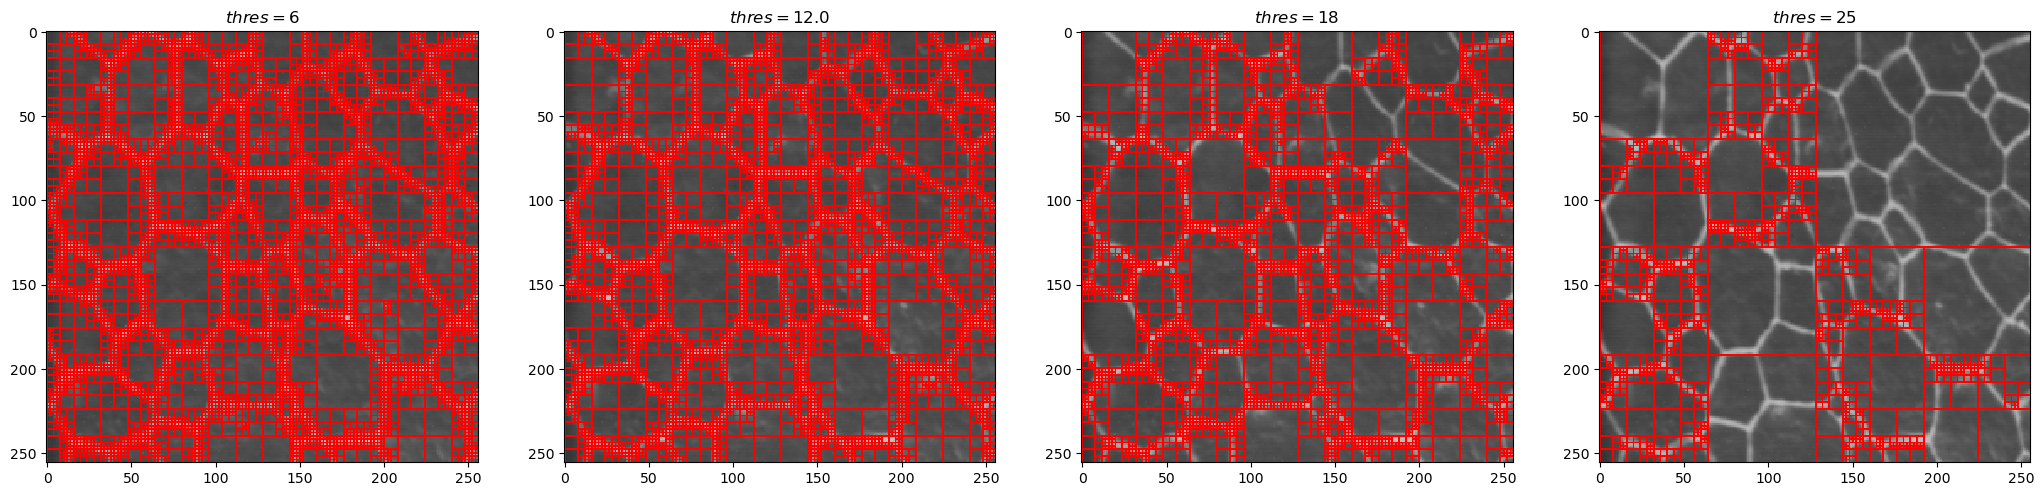

In [17]:
print("Standard deviation of `prisme`:", prisme.std())
niceDisplay14([computeSplit(prisme, 6), computeSplit(prisme, prisme.std()//2), 
               computeSplit(prisme, 18), computeSplit(prisme, 25)],
              titres=[f"$thres=6$", f"$thres={prisme.std()//2}$", "$thres=18$", "$thres=25$"])

In [18]:
std = prisme.std()
pred = np.linspace(0, std)
anim = animation.FuncAnimation(plt.figure(figsize=(4,4)), animateSplit, frames=pred, fargs=(prisme,"prisme",), 
                               interval=800, repeat=True)
anim.save('gif/prisme_splitting_algorithm.gif')
plt.close()

![Threshold value impact on split algorithm illustrated on prisme](gif/prisme_splitting_algorithm.gif)

Standard deviation of `seiche`: 21.512032237446647


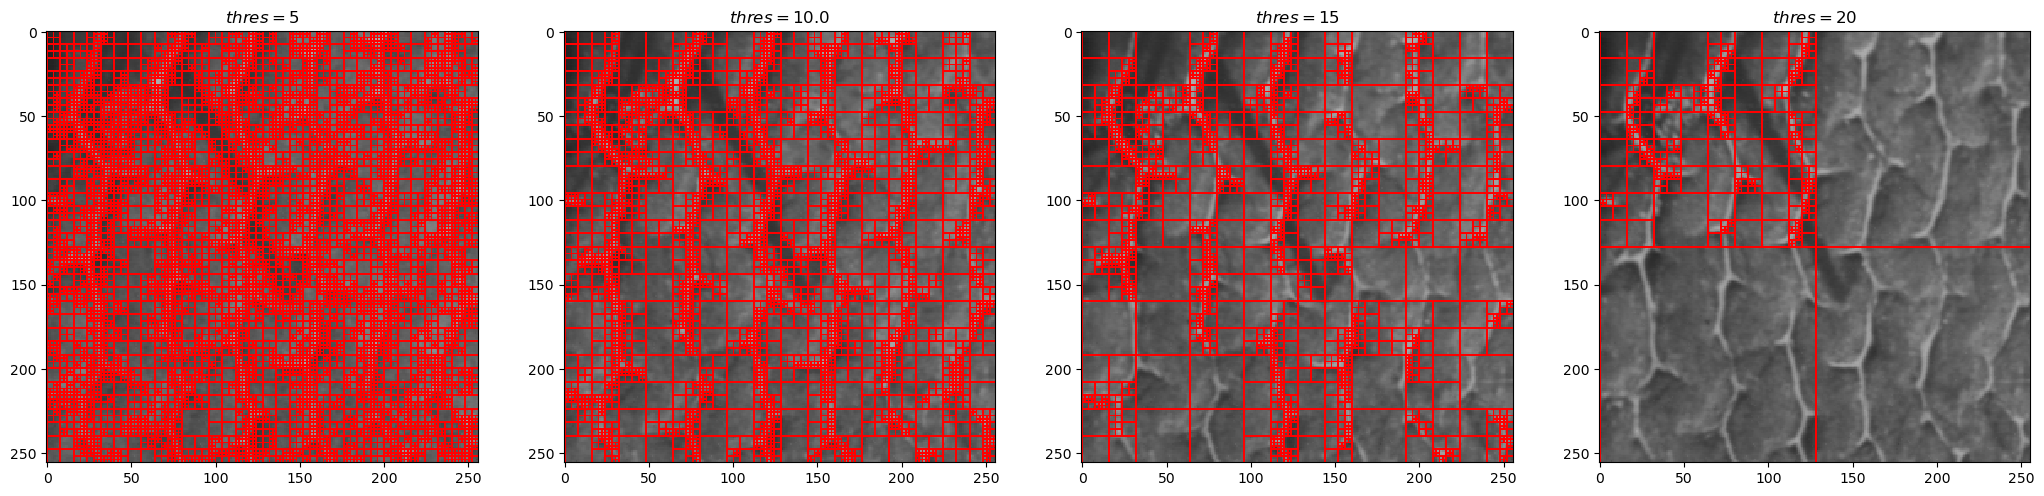

In [19]:
print("Standard deviation of `seiche`:", seiche.std())
niceDisplay14([computeSplit(seiche, 5), computeSplit(seiche, seiche.std()//2), 
               computeSplit(seiche, 15), computeSplit(seiche, 20)],
              titres=[f"$thres=5$", f"$thres={seiche.std()//2}$", "$thres=15$", "$thres=20$"])

In [20]:
std = seiche.std()
pred = np.linspace(0, std)
anim = animation.FuncAnimation(plt.figure(figsize=(4,4)), animateSplit, frames=pred, fargs=(seiche,"seiche",), 
                               interval=800, repeat=True)
anim.save('gif/seiche_splitting_algorithm.gif')
plt.close()

![Threshold value impact on split algorithm illustrated on seiche](gif/seiche_splitting_algorithm.gif)

## Exercise 3
### Question 1
Modify the function ``listRegions(L)`` to make it a function ``listRegionsStat(L,I)`` which computes the list of leaves of the quadtree ``L``. Each element of this list will be enriched with three scalar values: the first being the size, the second the mean and the third the variance of pixel values of the block in the image ``I``. This function then returns a list whose elements have the following formal type:
```python
type BlockStat = tuple[int**4,int,float**2]
```

The first four values are those of the ``Block`` type, the fifth is the size of the block (in number of pixels) and the last two values are the mean and variance calculated over the region.

In [23]:
# type BlockStat = tuple[int**4,int,float**2]

def listRegionsStat(L,I):
    """ QuadTree*Array -> list[BlockStat] """
    reg = []
    if len(L) == 1:
        x,y,n,m = L[0]
        reg.append((x, y, n, m, n*m, I[x:x+n,y:y+m].mean(), I[x:x+n,y:y+m].var()))
    else:
        for i in range(4):
            reg += listRegionsStat(L[i], I)
    return reg
    
print("Regions enriched with their statistics (img_test):\n", listRegionsStat(quadtree, img_test))

Regions enriched with their statistics (img_test):
 [(0, 0, 32, 32, 1024, 150.0, 0.0), (0, 32, 8, 8, 64, 150.0, 0.0), (0, 40, 8, 8, 64, 150.0, 0.0), (8, 32, 8, 8, 64, 150.0, 0.0), (8, 40, 8, 8, 64, 50.0, 0.0), (0, 48, 8, 8, 64, 150.0, 0.0), (0, 56, 8, 8, 64, 150.0, 0.0), (8, 48, 8, 8, 64, 50.0, 0.0), (8, 56, 8, 8, 64, 150.0, 0.0), (16, 32, 8, 8, 64, 150.0, 0.0), (16, 40, 8, 8, 64, 50.0, 0.0), (24, 32, 8, 8, 64, 150.0, 0.0), (24, 40, 8, 8, 64, 150.0, 0.0), (16, 48, 8, 8, 64, 50.0, 0.0), (16, 56, 8, 8, 64, 150.0, 0.0), (24, 48, 8, 8, 64, 150.0, 0.0), (24, 56, 8, 8, 64, 150.0, 0.0), (32, 0, 16, 16, 256, 150.0, 0.0), (32, 16, 16, 16, 256, 100.0, 0.0), (48, 0, 16, 16, 256, 150.0, 0.0), (48, 16, 16, 16, 256, 150.0, 0.0), (32, 32, 16, 16, 256, 100.0, 0.0), (32, 48, 16, 16, 256, 150.0, 0.0), (48, 32, 16, 16, 256, 150.0, 0.0), (48, 48, 16, 16, 256, 150.0, 0.0)]


### Question 2
In the remainder, the formal type is considered:
```python
type Region = list[BlocStats]
```
A region, as seen during the tutorial work, is therefore a list of blocks. Write the predicate ``predmerge(b,R,*args)`` as seen in tutorial work. This function returns ``True`` if the ``b`` block should merge into the ``R`` region. If a merge happens, then the first item of ``R`` will have its statistics updated to describe the statistics of the region ``R`` merged with `b`.

We remind that:
$$\mu = \frac{n_1\mu_1+n_2\mu_2}{n_1+n_2}\\
\sigma = \frac{n_1 (\sigma_1^2+\mu_1^2) + n_2(\sigma_2^2 + \mu_2^2)}{n_1+n_2} - \mu²$$

In [76]:
def predmerge(b,R,*args):
    """ BlocsStat*Region*... -> bool 
        If merge, R[0] is modified
    """
    n1,mu1,sigma1 = b[4:]
    x,y,w,h,n2,mu2,sigma2 = R[0]
    
    n = n1+n2
    mu = (n1*mu1 + n2*mu2) / n
    var = (n1*(sigma1*sigma1 + mu1*mu1) + n2*(sigma2*sigma2 + mu2*mu2)) / n - mu*mu   
    
    if var < args[0]*args[0]:
        R[0] = x, y, w, h, n, mu, var
        return True
    return False

### Question 3
Using `predmerge()` and `neighbors()` functions, given at the beginning of the notebook, write the function ``merge()`` discussed in tutorial work (exercise 7.5).

Recalls on Python lists:
- Remove an element `a` from a list `L`: `L.remove(a)`
- Test if `a` belongs to a list `L`: `a in L` 
- Iterate the elements of a list `L`: `for a in L:`
- Access to an element of a list: as with numpy arrays

In [49]:
def merge(S,I,pred,*args):
    """ QuadTree*Array*(BlockStat*Region*...->bool) -> list[Region]
        Merge the leaves of S in a list of regions
    """
    K = listRegionsStat(S, I)
    L = []
    while len(K) > 0:
        b = K[0]
        K.remove(b)
        R = [b]
        N = neighbors(b,K)
        for bi in N:
            if pred(bi,R,*args):
                K.remove(bi)
                R.append(bi)
                N += [bj for bj in neighbors(bi, K) if not bj in N] 
                # for bj in neighbors(bi,K):
                #     if not bj in N:
                #         N.append(bj)
        L.append(R)
    return L

### Question 4
Test the previous functions using the synthetic image `img_test`. In particular, check that merge() returns a list of 3 elements (i.e. 3 regions).

In [68]:
QT = split(img_test, (0,0,n,m), predsplit, 0)
M = merge(QT, img_test, predmerge, 1)
print("len(M) =",len(M))
assert len(M) == 3

len(M) = 3


In [84]:
QT_blurred = split(img_test_blurred, (0,0,n,m), predsplit, 6)
M_blurred = merge(QT_blurred, img_test_blurred, predmerge, 6)
print("len(M) =",len(M_blurred))

len(M) = 25


### Question 5
Write a function ``regions(LR,shape)`` that takes as arguments a list of regions (such as returned by the function ``merge()``) and an image size, and returns an image of the regions. Each region will be colored with the gray level corresponding to the average of the region. The ``shape`` parameter gives the size of the image to be produced. 

Test the function on the previous example.

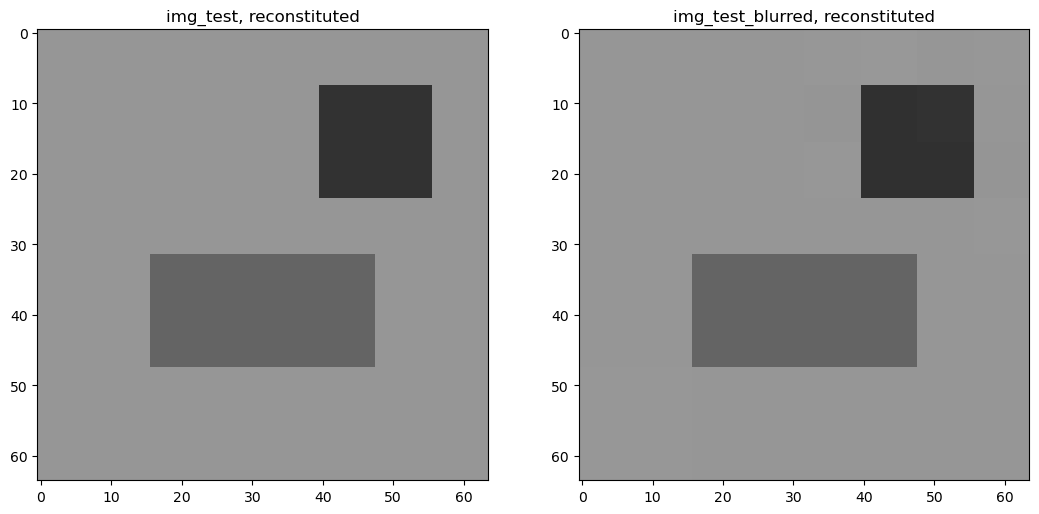

In [87]:
def regions(LR,shape):
    """ list[Region] -> Array """
    img = np.zeros(shape)
    for R in LR:
        for b in R:
            x,y,w,h,n,mu,var = b
            img[x:x+w,y:y+h] = mu
    return img

niceDisplay14([regions(M, img_test.shape), regions(M_blurred, img_test_blurred.shape)],
              titres=["img_test, reconstituted","img_test_blurred, reconstituted"])

## Exercise 4: experiments
### Question 1
Test the function ``merge()`` on the images ``angio``, ``cam``, ``muscle``, ``prisme`` and ``seiche``. Try to produce the best segmentations.

In [90]:
def animateMerge(pred, I, name=""):
    n, m = I.shape
    qt = split(I, (0,0,n,m), predsplit, pred)
    m = merge(qt, I, predmerge, pred)
    plt.imshow(regions(m, I.shape), cmap="gray")
    plt.title(f"{name}, $thres={round(pred,2)}$, regions$={len(m)}$")

def computeMerge(I, *args):
    """ Array -> Array
        computes quadtree, regions and the image where the regions has been traced 
        given an image
    """
    n, m = I.shape
    qt = split(I, (0,0,n,m), predsplit, args[0])
    m = merge(qt, I, predmerge, args[0])
    return regions(m,I.shape)

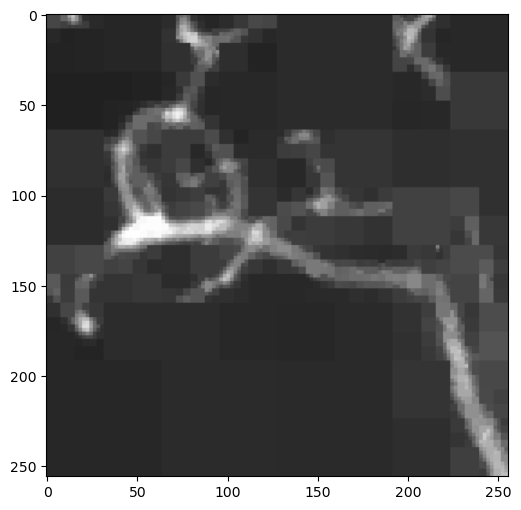

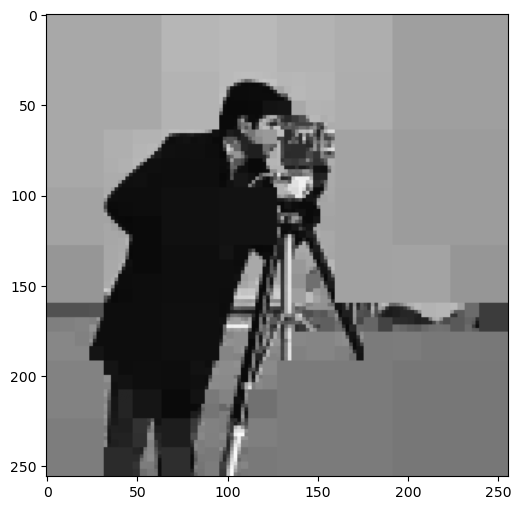

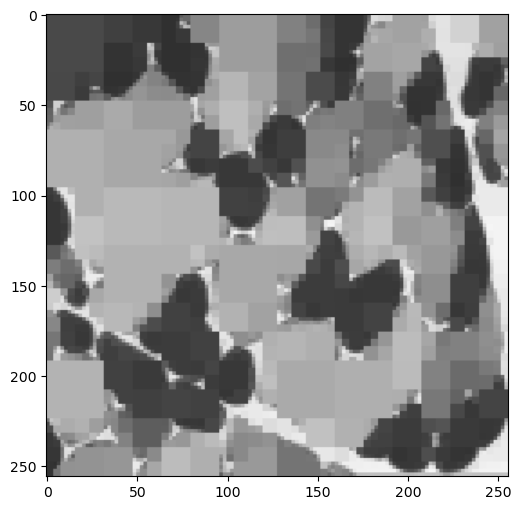

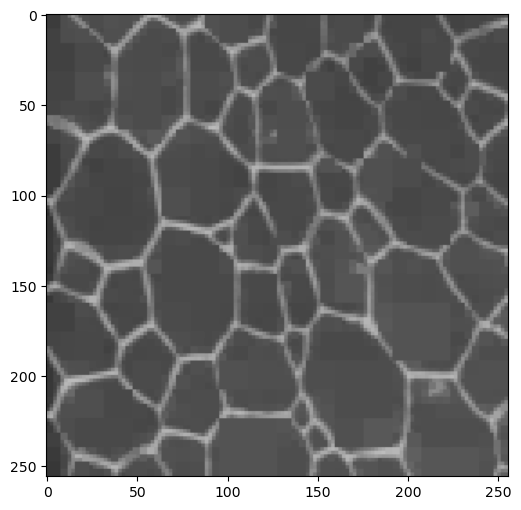

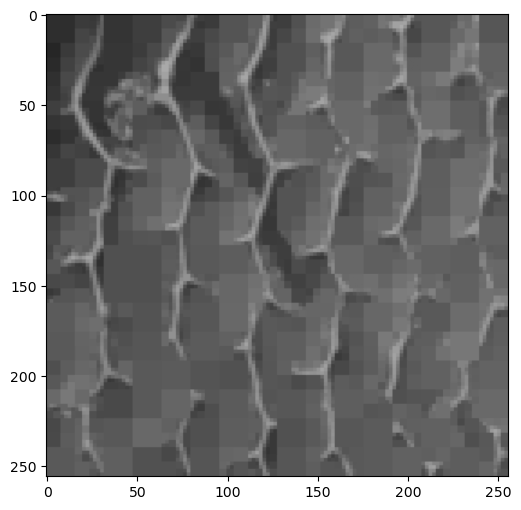

In [92]:
imshow(computeMerge(angio,angio.std()/2))
imshow(computeMerge(cam,cam.std()/2))
imshow(computeMerge(muscle,muscle.std()/2))
imshow(computeMerge(prisme,prisme.std()/2))
imshow(computeMerge(seiche,seiche.std()/2))

### Question 2
The result of the merge algorithm highly depends on how you visit the regions. One can then sort the leaves of the quadtree, for example, from the smallest to the largest blocks, or the opposite (use the Python function ``sorted()``). 
The same question arises when calculating the set of neighbors of the merged region. Should they be sorted? If yes, according to which criteria? their size? their proximity? 
Obviously there is no universal answer but it should be adapted to each type of problem. 
Do some tests to see the influence of these sortings on the result of the merger.

In [93]:
def merge(S,I,pred,sort="fwd",sortNeighbors=True,*args):
    """ QuadTree*Array*(BlockStat*Region*...->bool) -> list[Region]
        Merge the leaves of S in a list of sorted regions
        Regions can be sorted either from smallest to largest blocks ("fwd","forward") (default)
        or from largest to smallest blocks ("bwd", "backward") 
        Neighbors can also be sorted
    """
    # error checking
    isSortValid = ["fwd", "bwd", "forward", "backward"]
    sort = sort.lower()
    if sort not in isSortValid:
        raise ValueError("sort parameter must be one of those: %r" % isSortValid)
        
    K = listRegionsStat(S, I)
    
    # sorting
    if sort=="fwd":
        K = sorted(K, key=lambda b: b[4]) # smallest to largest blocks
    if sort=="bwd":
        K = sorted(K, key=lambda b: b[4], reverse=True) # largest to smallest blocks

    # merge algorithm
    L = []
    while len(K) > 0:
        b = K[0]
        K.remove(b)
        R = [b]
        N = neighbors(b,K)
        for bi in N:
            if pred(bi,R,*args):
                K.remove(bi)
                R.append(bi)
                N += [bj for bj in neighbors(bi, K) if not bj in N] 
                # for bj in neighbors(bi,K):
                #     if not bj in N:
                #         N.append(bj)
        L.append(R)
    return L



### Question 3 (bonus)
Imagine and experiment alternative predicates for both the split and the merge steps. It is possible to use edges-based predicates, and also to combine with variance-based predicates.
